<a href="https://colab.research.google.com/github/MichalBalcerak/ML24-25/blob/main/Homework04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
import matplotlib.pyplot as plt

I generated data based on linear relationship:
$$y=\beta_0+\beta_1x_1+\dots+\beta_nx_n+\epsilon
$$
where
$$\epsilon\sim\mathcal{N}(0,\sigma^2)$$
All these parameters were known (estabilished):\
I selected $\sigma^2=1$, $n=50$, and only 6 of $\beta_i\neq0$. My test set size was 1500.

In [3]:
n_test = 1500
n_features = 50
n_non_zero_betas = 5
noise_var = 1.0

np.random.seed(42)

beta = np.zeros(n_features)
nonzero_indices = np.random.choice(n_features, n_non_zero_betas, replace=False)
beta[nonzero_indices] = np.random.randn(n_non_zero_betas)
beta = np.hstack((np.random.randn(1), beta))


true_X = np.random.randn(n_test, n_features)
true_X = np.hstack((np.ones((n_test, 1)), true_X))

true_y = true_X @ beta + np.random.normal(0, noise_var, size=n_test)


I implemented LASSO and RIDGE regression for 50 different $\alpha$ values (on a geometric scale). For each $\alpha$, I performed 100 trials to calculate **MSE**, **variance** and **bias** across trials. First, I defined function that is used to train and evaluate the model.  In each iteration, a new training sample of size 100 is drawn, the model is fitted, and the bias, variance, and MSE are estimated.\
To compute MSE I use the following decomposition:
$$ MSE = Bias^2 + Var + \sigma^2$$
where\
MSE is the mean squared error\
*Bias^2* is the squared difference between the average prediction and the true value of y at a given point, where the average is taken over all trials\
*Var* is the variance of the predictions at a given point\
$\sigma^2$ is the noise variance used to generate true y data

To estimate the above metrics the average was taken over all data points.

In [4]:
alphas = np.logspace(-4, 3, 50)
n_trials = 100
n_samples = 100
def evaluate_model(ModelClass):
    bias2_list = []
    var_list = []
    mse_list = []

    for alpha in alphas:
        predictions = []
        for i in range(n_trials):
            X_sample = np.random.randn(n_samples, n_features)
            X_sample = np.hstack((np.ones((n_samples, 1)), X_sample))
            noise_sample = np.random.normal(0, noise_var, size=n_samples)
            y_sample = X_sample @ beta + noise_sample

            model = ModelClass(alpha=alpha)
            model.fit(X_sample, y_sample)
            y_pred = model.predict(true_X)
            predictions.append(y_pred)

        predictions = np.array(predictions)
        mean_pred = np.mean(predictions, axis=0)

        bias2 = np.mean((mean_pred - true_y) ** 2)
        var = np.mean(np.var(predictions, axis=0))
        total_mse = bias2 + var + noise_var

        bias2_list.append(bias2)
        var_list.append(var)
        mse_list.append(total_mse)

    return bias2_list, var_list, mse_list



I used the function defined above to train and evaluate Ridge and Lasso models.

In [5]:
ridge_bias, ridge_var, ridge_mse = evaluate_model(Ridge)
lasso_bias, lasso_var, lasso_mse = evaluate_model(Lasso)

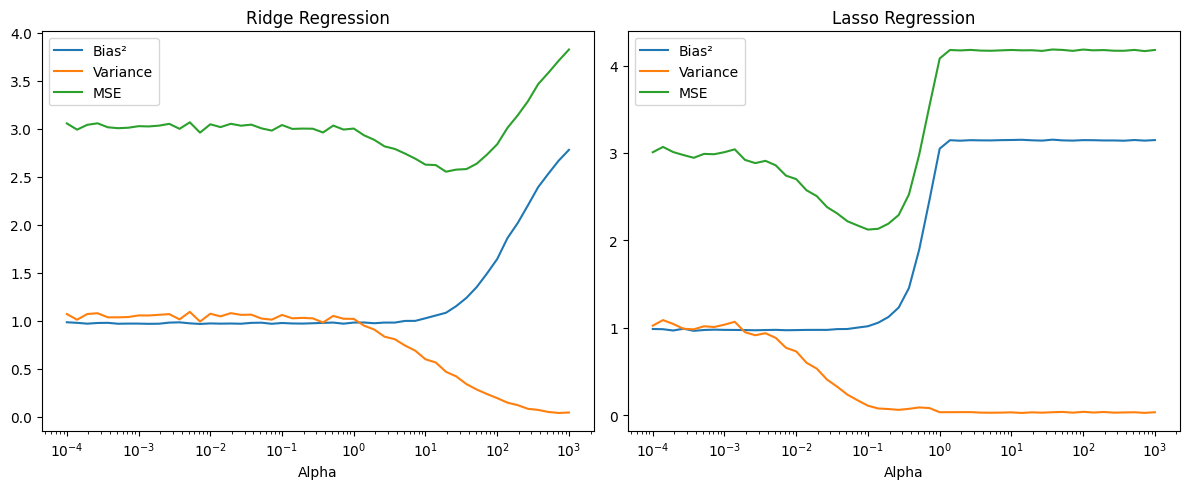

In [6]:
plt.figure(figsize=(12, 5))

# Ridge
plt.subplot(1, 2, 1)
plt.plot(alphas, ridge_bias, label="Bias²")
plt.plot(alphas, ridge_var, label="Variance")
plt.plot(alphas, ridge_mse, label="MSE")
plt.xscale("log")
plt.title("Ridge Regression")
plt.xlabel("Alpha")
plt.legend()

# Lasso
plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_bias, label="Bias²")
plt.plot(alphas, lasso_var, label="Variance")
plt.plot(alphas, lasso_mse, label="MSE")
plt.xscale("log")
plt.title("Lasso Regression")
plt.xlabel("Alpha")
plt.legend()

plt.tight_layout()
plt.show()


# How does varying the regularization parameter  λ  in Ridge and Lasso regression impact the trade-off between bias and variance?


As we can see above, increasing the regularization parameter $\alpha$ (lambda) in Ridge and Lasso regression increases the bias —because we impose a stronger penalty on large model coefficients. At the same time, it decreases the variance, as the model becomes simpler.

The Mean Squared Error (MSE) — which can be decomposed into bias² + variance + irreducible error — decreases initially, reaches a minimum at an optimal value of $\alpha$ (where the model generalizes well - as we discussed in class, in practice we often choose a slightly larger value of the parameter), and then increases again as the model becomes too simple to capture the underlying data patterns.

# Does the regularization lead to an optimal trade-off point where MSE is minimized? Explain why this point exists.

Yes, regularization leads to an optimal trade-off point where MSE is minimized.\
We observed this in our experiments — the MSE curve displayed a characteristic U-shape. In general, such an optimal point exists because MSE is the sum of bias², variance, and irreducible noise, and $bias^2$ and variance  exhibit opposite trends as the regularization parameter $\alpha$ (lambda) increases. Assuming a theoretical setting, both $bias^2$ and variance can be treated as continuous functions of $\alpha$, and by the *Weierstrass Extreme Value Theorem*, we know that their sum (MSE) must attain a minimum on a closed and bounded interval.
Thus, an optimal value of $\alpha$ exists.




# How Ridge and Lasso differ in terms of their bias-variance trade-offs?

In Lasso regression, as the regularization parameter $\alpha$ increases, the bias increases more sharply than in Ridge regression. This is due to Lasso's ability to set some coefficients exactly to zero, simplifying the model aggressively. For sufficiently large values of $\alpha$, all coefficients can be reduced to zero, resulting in a model with very high bias what we can see on the above plot. However, this simplification also causes the variance to decrease more rapidly compared to Ridge regression, as the model becomes less flexible. Ridge regression, on the other hand, shrinks coefficients but does not eliminate them entirely, resulting in a more gradual bias increase and a slower variance reduction.

# Discuss situations where one method may outperform the other, considering factors like feature sparsity and multicollinearity

Generally, due to its tendency to reduce coefficients exactly to zero, Lasso may be better in situations where we expect that some features are unimportant and their influence can be omitted from the analysis. A great example of this is the dataset used in the analysis, where only a few coefficients were non-zero, and the Lasso regression performed better than the Ridge regression, meaning that the MSE was lower for the former.\
On the other hand, in cases of multicollinearity, when there are many coefficients with minor impact, it may be better to use Ridge regression because this technique does not strongly penalize small coefficient values — in contrast to Lasso, which may disregard the contribution of all relevant features.

